#### Basics

In [ ]:
# make the figures that might be used in main text
import itertools
import numpy as np
from random import choice
import pickle
import matplotlib.pyplot as plt
from math import *
import scipy
from tqdm import tqdm
import copy
import seaborn as sns
from collections import defaultdict
import pickle

from lag_test_utils_leaky_mod import *
from scipy.optimize import root_scalar

import matplotlib as mpl
import pandas as pd
from colorsys import rgb_to_hls, hls_to_rgb
import seaborn as sns


# Set the default font and size
# mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 14
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

In [2]:
# functions and variables might be used later

def get_shannon_index(sample):
    info = [[], [], []]
    for idx, name in enumerate(sample[1]["ids"]):
        for spc in sample[0]:
            if(spc.id==name and spc.cat=="Seq"):
                info[0].append(spc.phi)
                info[1].append(spc.pref[0])
            elif(spc.id==name and spc.cat=="Cout"):
                info[0].append(spc.phi)
                info[1].append(1)
        info[2].append(sample[1]["bs"][-1][idx])
    phis, prefs, bs = info
    sum_dict = defaultdict(float)
    for phi, pref, b in zip(phis, prefs, bs):
        sum_dict[(phi, pref)] += b
    abundances = list(sum_dict.values())
    proportions = np.array(abundances) / sum(abundances)
    return np.exp(-sum(p * np.log(p) for p in proportions if p > 0))

# Define soft colors
soft_red = '#f61010'
soft_blue = '#0000ff'
soft_blue1 = '#5555ff'
soft_purple = "#B39DEB"
soft_green = '#58C358'
colors_list = [(0.0, soft_blue),    # -4 (maps to 0.0 in normalized space)
               (1+log10(0.01)/4, soft_blue1), # -2 (maps to 0.5)
               (1+log10(0.1)/4, soft_purple),     # -1 (maps to 0.75)
               (1.0, soft_red)]     # 0 (maps to 1.0 in normalized space)
cmap_rb = mcolors.LinearSegmentedColormap.from_list('custom_rb', colors_list)
green_cmap = mcolors.ListedColormap([soft_green])

# or just use grayscale
# colors_list = [(0.0, "w"),    # -4 (maps to 0.0 in normalized space)
#             #    (1+log10(0.01)/4, soft_blue1), # -2 (maps to 0.5)
#                (1+log10(0.1)/4, "gray"),     # -1 (maps to 0.75)
#                (1.0, "k")]     # 0 (maps to 1.0 in normalized space)
# cmap_gray = mcolors.LinearSegmentedColormap.from_list('custom_rb', colors_list)
colors_list = [(0.0, "w"),    # -4 (maps to 0.0 in normalized space)
               (1+log10(0.01)/4, "gray"),     # -1 (maps to 0.5)
               (1.0, "k")]     # 0 (maps to 1.0 in normalized space)
cmap_gray = mcolors.LinearSegmentedColormap.from_list('custom_rb', colors_list)

# define phase diagram colors
# Create the colormap
soft_red2 = '#C35858'
soft_blue2 = '#5858C3'
cmap_phase = ListedColormap([soft_green, soft_blue2, soft_red2])

def get_frac_b1(sample):
    abund_b1, abund_b2 = 0, 0
    for idx, name in enumerate(sample[1]["ids"]):
        for spc in sample[0]:
            if(spc.id==name):
                if(spc.pref==(1, 2)):
                    abund_b1 += sample[1]["bs"][-1][idx]
                else:
                    abund_b2 += sample[1]["bs"][-1][idx]
    return abund_b1, abund_b2
                
def get_phi(sample, strat):
    thres = -1
    pairs = []
    for idx, name in enumerate(sample[1]["ids"]):
        for spc in sample[0]:
            if(spc.id==name and strat in spc.id and spc.phi>thres):
                if(spc.phi==0.0001):
                    pairs.append((MIN_PHI, sample[1]["bs"][-1][idx]))
                else:
                    pairs.append((spc.phi, sample[1]["bs"][-1][idx]))
    return pairs

#### Growth and resource depletion of leaky diauxer

4.479398673080554


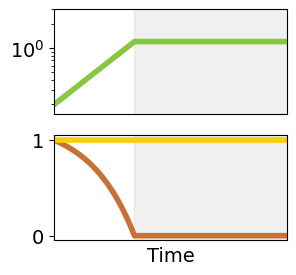

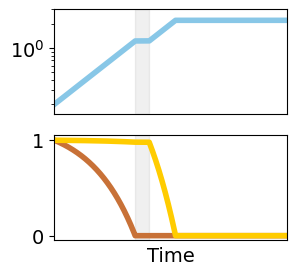

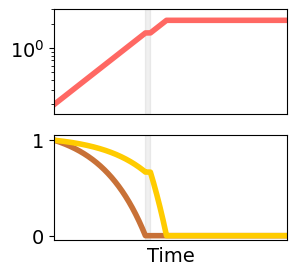

In [3]:
b0 = 2e-1
Rs = np.array([1.0, 1.0])
T_dilute = 24
g11, q, p = 0.4, 0.0, 1.0
g12 = g11*(1-q)*p
tau0 = 0.2

brown = "#deaa87"
yellow = "#ffd42a"

def make_growth_plots(phi, c_spc):
    b = LeakySeqUt(phi=phi, g_enz=np.array([g11, g12]), gC=1.0, pref_list=(1, 2), tau0=tau0, biomass=b0, id="1")
    C = EcoSystem([b])
    C.OneCycle(Rs, T_dilute)
    if(phi>1e-10):
        t1, tau, t2 = np.array(C.last_cycle["ts"][1:4])
        t1s = np.linspace(0, t1, 1000)
        b.GetEating(np.array([1.0, 1.0]))
        b1s = b0*np.exp(b.GetGrowthRate()*t1s)
        r11s = Rs[0] - (b1s-b0)*b.GetDep()[0]
        r21s = Rs[1] - (b1s-b0)*b.GetDep()[1]
        t2s = np.linspace(tau, t2, 1000)
        b.GetEating(np.array([0.0, 1.0]))
        b2s = b1s[-1] * np.exp(b.GetGrowthRate()*(t2s-tau))
        r12s = 0*t2s
        r22s = r21s[-1] - (b2s-b1s[-1])*b.GetDep()[1]
    else:
        t1 = np.array(C.last_cycle["ts"][1])
        print(t1)
        t1s = np.linspace(0, t1, 1000)
        b.GetEating(np.array([1.0, 1.0]))
        b1s = b0*np.exp(b.GetGrowthRate()*t1s)
        r11s = Rs[0] - (b1s-b0)*b.GetDep()[0]
        r21s = Rs[1] - (b1s-b0)*b.GetDep()[1]
        t2s = np.array([24])
        b2s = np.array([b1s[-1]])
        r12s =np.array([r11s[-1]])
        r22s = np.array([r21s[-1]])

    fig, axs = plt.subplots(2, 1, figsize=(3, 3))
    axs[0].plot(np.concatenate([t1s, t2s, [24]]), np.concatenate([b1s, b2s, [b2s[-1]]]), color=c_spc, linewidth=4)
    axs[0].set_xlim(0, 13)
    axs[0].set_ylim(1.5e-1, 3)
    axs[0].set_yscale("log")
    axs[0].set_xticks([], [])
    # axs[0].axvspan(t1s[0], t1s[-1], color=brown, alpha=0.2)
    axs[0].axvspan(t1s[-1], t2s[0], color="k", alpha=0.06)
    # axs[0].axvspan(t1s[0], t2s[-1], color=yellow, alpha=0.2)

    axs[1].plot(np.concatenate([t1s, t2s, [24]]), np.concatenate([r11s, r12s, [r12s[-1]]]), color="#c87137", linewidth=4)
    axs[1].plot(np.concatenate([t1s, t2s, [24]]), np.concatenate([r21s, r22s, [r22s[-1]]]), color="#ffcc00", linewidth=4)
    axs[1].set_xlim(0, 13)
    axs[1].set_xticks([], [])
    axs[1].set_xlabel("Time")
    axs[1].axvspan(t1s[-1], t2s[0], color="k", alpha=0.06)
    # plt.show()

make_growth_plots(1e-11, "#88c741")
# plt.savefig("figs/vers2/fig1_dyn_1.pdf", bbox_inches="tight")
make_growth_plots(0.04, "#88c7e7")
# plt.savefig("figs/vers2/fig1_dyn_2.pdf", bbox_inches="tight")
make_growth_plots(0.5, "#ff6863")
# plt.savefig("figs/vers2/fig1_dyn_3.pdf", bbox_inches="tight")

#### Dirichlet distribution

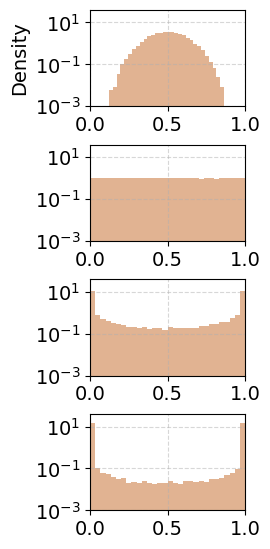

In [83]:
# dirichlet distribution
from matplotlib.patches import bbox_artist
from networkx import density
import numpy as np
import matplotlib.pyplot as plt

n_samples = 40000

fig, axs = plt.subplots(4, 1, figsize=(2, 6.5))
plt.subplots_adjust(wspace=0.5, hspace=0.4) 
alphas = [0.01, 0.1, 1.0, 10.0]

for idx, a in enumerate(alphas[::-1]):
    samples = np.random.dirichlet(alpha=[a, a], size=n_samples)

    row, col = 0, idx
    
    axs[idx].hist(samples[:, 0].flatten(), bins=30, alpha=0.53, color="#c87131", density=True)
    # axs[idx].set_title(f'α = {a:.2f}')
    axs[idx].set_xlim(0, 1)
    axs[idx].grid(True, linestyle='--', alpha=0.5)
    
    if row == 1:
        axs[idx].set_xlabel('R supply')
    if col == 0:
        axs[idx].set_ylabel('Density')
    axs[idx].set_yscale("log")
    axs[idx].set_ylim(0.001, 40)
    # axs[idx].set_xlabel("$R_1$ supply")

# plt.suptitle('Dirichlet Distributions', y=1.02, fontsize=14)
plt.savefig("figs/vers2/fig2_dirichlet.pdf", bbox_inches="tight")
plt.show()

#### Evolutionary dynamics

In [3]:
p_mutate = 1/20
p_mutate_pref = 1/100
phi_lo = 1e-4
phi_hi = 5e-1
log_step = 0.2

def rRandom(nR, alpha, cycle):
    zero_thr = 1e-8
    if(alpha==0):
        result = choice([i for i in np.eye(nR)])
    elif(alpha=="max"):
        result = np.array([0.5 for i in range(nR)])
    else:
        result = np.round(np.random.dirichlet([alpha]*nR), 10)
        if(np.isnan(result).any() or np.isinf(result).any()):
            result = choice([i for i in np.eye(nR)])
    if(0 in result):
        result = (1-len(result)*zero_thr)*result+zero_thr
    return result

from scipy.special import beta, betainc
def minExpectation(alpha): # expectation of min(R1, R2) for dirichlet(alpha, alpha)
    if(alpha=="max"):
        return 0.5
    elif(alpha==0):
        return 0.0
    else:
        integral = betainc(alpha+1, alpha, 0.5)
        return 2 * integral * beta(alpha+1, alpha) / beta(alpha, alpha)
def rProtocol(nR, alpha, cycle): # now only work for nR=2
    zero_thr = 1e-8
    k = 1 
    x1 = minExpectation(alpha)
    Rlist = [np.array([x1, 1-x1]) for i in range(k)] + [np.array([1-x1, x1]) for i in range(k)]
    result = Rlist[ cycle%len(Rlist) ]
    if(0 in result):
        result = (1-len(result)*zero_thr)*result+zero_thr
    return result

def phiMutate(phi_now, phi_hi=phi_hi, phi_lo=phi_lo, log_step=log_step):
    # Initial state jumps directly to phi_lo
    if phi_now < phi_lo:
        return phi_lo
    # Convert to logarithmic space for uniform steps
    log_now = np.log10(phi_now)
    # 50% probability for up/down mutation
    direction = np.random.choice([1, -1]) 
    new_log = log_now + direction * log_step
    # Handle boundary conditions
    if new_log > np.log10(phi_hi):
        return phi_hi
    elif new_log < np.log10(phi_lo):
        return 1e-200/2  # Reset to near-zero value
    else:
        return 10**new_log
    
def color_conv(color):
    return f"#{color[0]:02x}{color[1]:02x}{color[2]:02x}"

def phi_to_color(phi, color_A, color_B, color_C):
    if(phi<0.03):
        log_phi_min, log_phi_max = -4, np.log10(0.03)
        log_phi = np.log10(phi)
        t = (log_phi - log_phi_min) / (log_phi_max - log_phi_min)
        t = np.clip(t, 0, 1)  # Keep within range
        color = (1 - t) * color_A + t * color_B
        color = np.clip(color, 0, 255).astype(int)
    else:
        log_phi_min, log_phi_max = np.log10(0.03), log(1/2)
        log_phi = np.log10(phi)
        t = (log_phi - log_phi_min) / (log_phi_max - log_phi_min)
        t = np.clip(t, 0, 1)  # Keep within range
        color = (1 - t) * color_B + t * color_C
        color = np.clip(color, 0, 255).astype(int)
    return color_conv(color)
    
def vis_biomass(id_list, blist, phi_list=None):
    '''
    id_list: list of list of int; each element is the ID of species that are present at the end of a cycle
    blist: list of np.array of float; each element is the abundance of species at the end of a cycle
    '''
    all_keys = set(sum(id_list, []))
    all_info_dict = {key:[] for key in all_keys}
    phi_dict = {key:1e-4 for key in all_keys}
    for cycle, ids in enumerate(id_list):
        for key in all_keys:
            all_info_dict[key].append(0)
        for idx, id in enumerate(ids):
            all_info_dict[id][-1] = blist[cycle][idx]
    for cycle, ids in enumerate(id_list):
        for idx, id in enumerate(ids):
            phi_dict[id] = phi_list[cycle][idx]
    if(phi_list is None):
        for key in all_info_dict:
            plt.plot(range(len(blist)), all_info_dict[key], label=key)
    else:
        for key in all_info_dict:
            red, purple, blue, lightgreen = np.array([255, 104, 99]), np.array([180, 157, 255]), np.array([135, 199, 255]), np.array([112,199,156])
            green = np.array([135,199,63])
            if("seq" in key):
                plt.plot(range(len(blist)), all_info_dict[key], lw=2, color=phi_to_color(phi_dict[key], lightgreen, blue, red))
                # plt.plot(range(len(blist)), all_info_dict[key], lw=1.5, color="#5757c2")
            else:
                plt.plot(range(len(blist)), all_info_dict[key], lw=2, color=color_conv(green))

    plt.yscale("log")
    plt.xlabel("Dilution cycles")
    # plt.ylabel("Species abundance")


  1%|          | 134/20000 [00:00<00:15, 1322.37it/s]

100%|██████████| 20000/20000 [01:07<00:00, 294.94it/s]


[0.18104206108963353, 0.49862409388458445, 0.13152852430261086, 0.21704305065839935]
[1.01007605e+00 1.18675682e-05 1.18956142e-05 1.19454905e-06] [1.01007604e+00 1.11380306e-05 1.26805695e-05 1.15199531e-06]
{'ids': ['2_seq800', '2_seq909', '2_seq956', '2_seq980'], 'ts': [0, 1.5110711737551034e-06, 0.34795290406438684, 0.7386993393507608, 0.7638312885649361, 0.8545144575722121, 1.014267279090269, 1.0866507323439738, 12.367437205806713, 24.0], 'cs': [array([9.9999998e-01, 1.0000000e-08, 1.0000000e-08]), array([9.99999979e-01, 9.44732928e-09, 0.00000000e+00]), array([9.99999979e-01, 9.44732928e-09, 0.00000000e+00]), array([0.99999997, 0.        , 0.        ]), array([0.99999997, 0.        , 0.        ]), array([0.99999997, 0.        , 0.        ]), array([0.99933345, 0.        , 0.        ]), array([0.99901714, 0.        , 0.        ]), array([0., 0., 0.]), array([0., 0., 0.])], 'bs': [array([1.01007604e-02, 1.11380306e-07, 1.26805695e-07, 1.15199531e-08]), array([1.01007715e-02, 1.1138

(1e-07, 2.2)

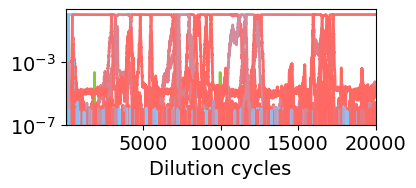

In [27]:
T_dilute = 24
Rs = np.array([1.0, 1.0])
D=100.0
gC = 1.0 # placeholder, no use

q = 0.0
pfrac = 0.5
index = 2
alpha = 10**-3.0
tau0 = 0.5
randomness = True
nR = 3

q = 1-(1-q)**(1/(nR-1))
gs = []
b_specs = []
for res in range(nR):
    gi = np.array([0.8*pfrac*(1-q)**i for i in range(nR)])
    gi[res] = gi[res]/pfrac
    gs.append(gi)
    # bi = LeakySeqUt(phi=MIN_PHI, g_enz=gi, gC=gC, pref_list=get_smart_pref(gi), tau0=tau0, biomass=0.01, id=f"{res}_spec{res}")
    bi = LeakySeqUt(phi=MIN_PHI, g_enz=gi, gC=gC, pref_list=get_rand_pref(res+1, nR), tau0=tau0, biomass=0.01, id=f"{res}_spec{res}")
    b_specs.append(bi)

spc_list = b_specs.copy()
for species in spc_list:
    species.RezeroLag()

N_cycles = 20000
C = EcoSystem(spc_list)
b_list, id_list, phi_list = [], [], []
last_10 = []
mutant_count = nR

for i in tqdm(range(N_cycles)):
    ######################          here switches random or seasonal          #################################
    if not randomness:
        Rs = rProtocol(nR, alpha, i) 
    else:
        Rs = rRandom(nR, alpha, i)
    C.OneCycle(Rs, T_dilute)
    b_list.append(C.last_cycle['bs'][-1])
    id_list.append(C.last_cycle['ids'])
    phi_list.append([i.phi for i in C.species if i.id in C.last_cycle['ids']])
    # print(C.last_cycle['ids'], C.last_cycle['bs'][-1])
    C.MoveToNext(D)
    if(np.random.rand()<p_mutate):
        # generate invader
        if(len(C.species)>0):
            spc = np.random.choice(C.species)
        else:
            spc = np.random.choice(b_specs)
        phi_mut = phiMutate(spc.phi, log_step=np.random.uniform(0.1, 1), phi_hi=(nR-1)/nR)
        b_mu = LeakySeqUt(phi=phi_mut, g_enz=spc.g, gC=gC, 
                pref_list=spc.pref, tau0=tau0, biomass=0.01, id=f"{spc.id[0]}_seq{mutant_count}")
        if(np.random.rand()<p_mutate_pref):
            b_mu = random.choice([i for i in b_specs])
        b_mu.RezeroLag()

        # check if there's an identical species in the community
        if(not any(spc.cat=="Seq" and spc.phi == b_mu.phi and spc.pref == b_mu.pref for spc in C.species)):
            C.Invade(b_mu)
            mutant_count += 1

    last_10.append([C.species, C.last_cycle])
    last_10 = last_10[-10:]

print([spc.phi for spc in last_10[-1][0]])
print(last_10[-1][1]["bs"][-1], last_10[-2][1]["bs"][-1])
print(C.last_cycle)
plt.figure(figsize=(4, 1.5))
vis_biomass(id_list[:], b_list[:], phi_list[:])
# plt.xscale("log")
plt.xlim(1, 20001)
plt.ylim(1e-7, 2.2)
# # plt.savefig(f"figs/vers2/fig2_dynamics_{index}.pdf", bbox_inches="tight")

#### The ridge plots

##### q=0

In [5]:
def make_hist(pairs, nbins, nR=2, makeplot=False):
    factor = nR/(nR-1)
    # a1_values = np.array([max(-4, np.log10(pair[0]*factor)) for pair in pairs])
    a1_values = np.array([max(-3, np.log10(pair[0]*factor)) for pair in pairs])
    a2_values = np.array([pair[1] for pair in pairs])
    # xlo, xhi = -4.01, 1.01
    xlo, xhi = -3.01, 1.01
    bins = np.linspace(xlo-(xhi-xlo)/(nbins-1), xhi, nbins + 1)
    bin_indices = np.digitize(a1_values, bins) - 1
    bin_heights = np.zeros(nbins)
    for i, bin_idx in enumerate(bin_indices):
        if 0 <= bin_idx < nbins:  # Ignore out-of-range values
            bin_heights[bin_idx] += a2_values[i]
    bin_centers = (bins[:-1] + bins[1:]) / 2
    if(makeplot):
        plt.figure(figsize=(5, 3))
        plt.bar(bin_centers, bin_heights, width=np.diff(bins), color="k", edgecolor='k', align='center', alpha=0.4)
        # plt.xlim(-4.1, 0.1)
        # plt.xticks([-4, -3, -2, -1, 0], ["$\\leq 10^{-4}$", "$10^{-3}$", "$10^{-2}$", "$10^{-1}$", "1"])
        # plt.axvline(-4, color="k", linestyle="-.")
        plt.xlim(-3.1, 0.1)
        plt.xticks([-3, -2, -1, 0], ["$\\leq 10^{-3}$", "$10^{-2}$", "$10^{-1}$", "1"])
        plt.axvline(-3, color="k", linestyle="-.")
        plt.xlabel("$\\phi\\cdot n_R$")
        plt.ylabel("Histogram")
    return bin_centers, bin_heights

/home/n-z/zihanw8/sci-comp/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/n-z/zihanw8/sci-comp/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


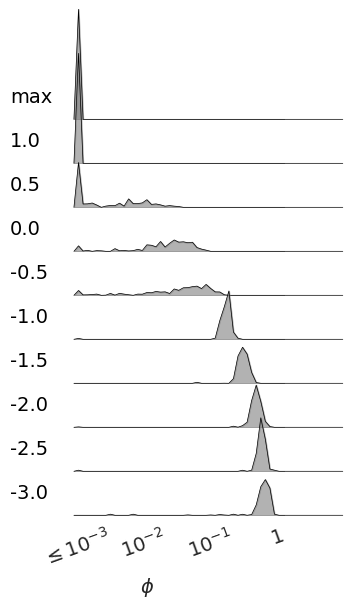

In [6]:
nR = 2
tau0, p, D= 0.3, 0.5, 100.0
q = 0.0
alphas = list(10**np.linspace(-3, 1, 9)) + ["max"]
alpha_names = list(np.linspace(-3, 1, 9)) + ["max"]
nbins = 60


freqs = []
x_values = []
for a in alphas[::-1]:
	q = 1-(1-q)**(1/(nR-1))
	data = pickle.load(open(f"data/with_leaky_1/evolution_with_cout_a={a}_q={q}_p={p}_D={D}_tau0={tau0}_random_nR={nR}_1.pkl", "rb"))
	all_pairs = []
	for sample in data:
		all_pairs.extend(get_phi(sample, "seq"))
		all_pairs.extend(get_phi(sample, "spec"))
	bin_centers, bin_heights = make_hist(all_pairs, nbins)
	x_values.append(bin_centers)
	freqs.append([i/np.sum(bin_heights) for i in bin_heights])

'''
df:
"x" - bin centers across 1e-5(0) to 1e0
"freq" - propto biomass
"g" - name of group, alpha here
'''
df_list = []
for idx, g in enumerate(alpha_names[::-1]):
	df_tmp = pd.DataFrame({
		"x": x_values[idx],
		"freq": freqs[idx],
		"g": g
	})
	df_list.append(df_tmp)
df = pd.concat(df_list, ignore_index=True)

# make ridgeplot
with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
	g = sns.FacetGrid(df, row="g", aspect=6, height=.6)
	g.l_idx = 0

	def ridgeplot(x, freq, color, **kwargs):
		ax = plt.gca()
		ax.plot(x, freq, color="k", lw=0.5, clip_on=False)
		# ax.plot([-4, 0.5], [0, 0], color="k", lw=1)
		ax.fill_between(x, 0, freq, color=color, alpha=0.6)
	g.map(ridgeplot, "x", "freq", color="gray")
	# g.refline(y=0, linewidth=1, linestyle="-", color="gray", clip_on=False)
	
	def label(x, color, **kwargs):
		ax = plt.gca()
		label = alpha_names[::-1][g.l_idx]
		g.l_idx += 1
		ax.text(0, 0.2, label, color=color,
				ha="left", va="center", transform=ax.transAxes)
	g.map(label, "x", color="k")

	g.figure.subplots_adjust(hspace=-.6)
	g.despine(bottom=True, left=True)

	# g.figure.set_size_inches(4, 8)
	# g.set(xlim=(-5, 0.5), 
	#    xticks=[-4, -3, -2, -1, 0],
	#    xticklabels=["$\\leq 10^{-4}$", "$10^{-3}$", "$10^{-2}$", "$10^{-1}$", "1"],
	g.set(xlim=(-4, 0.1), 
	   xticks=[-3, -2, -1, 0],
	   xticklabels=["$\\leq 10^{-3}$", "$10^{-2}$", "$10^{-1}$", "1"],
	   xlabel="",
      ylim=(0, 1.0), 
	  yticks=[], 
	  ylabel="", 
	  title="")
	# plt.show()
	for ax in g.axes.flat:
		plt.setp(ax.get_xticklabels(), rotation=20)
plt.xlabel("${\\phi}$")
plt.savefig("figs/vers2/fig2_fixq_hist_alt.pdf", bbox_inches="tight")

##### q>0

In [7]:
def make_hist(pairs, nbins, nR=2, makeplot=False):
    factor = nR/(nR-1)
    a1_values = np.array([max(-3, np.log10(pair[0]*factor)) for pair in pairs])
    a2_values = np.array([pair[1] for pair in pairs])
    xlo, xhi = -3.01, 1.01
    bins = np.linspace(xlo-(xhi-xlo)/(nbins-1), xhi, nbins + 1)
    bin_indices = np.digitize(a1_values, bins) - 1
    bin_heights = np.zeros(nbins)
    for i, bin_idx in enumerate(bin_indices):
        if 0 <= bin_idx < nbins:  # Ignore out-of-range values
            bin_heights[bin_idx] += a2_values[i]
    bin_centers = (bins[:-1] + bins[1:]) / 2
    if(makeplot):
        plt.figure(figsize=(5, 3))
        plt.bar(bin_centers, bin_heights, width=np.diff(bins), color="k", edgecolor='k', align='center', alpha=0.4)
        plt.xlim(-3.1, 0.1)
        plt.xticks([-3, -2, -1, 0], ["$\\leq 10^{-3}$", "$10^{-2}$", "$10^{-1}$", "1"])
        # plt.axvline(-4, color="k", linestyle="-.")
        plt.xlabel("$\\phi\\cdot n_R$")
        plt.ylabel("Histogram")
    return bin_centers, bin_heights

def get_phi_pref(sample, res):
    thres = -1
    pairs = []
    for idx, name in enumerate(sample[1]["ids"]):
        for spc in sample[0]:
            nR = len(spc.g)
            if(spc.id==name and spc.phi>thres and spc.pref[0]==res):
                if(spc.phi==0.0001):
                    pairs.append((MIN_PHI, sample[1]["bs"][-1][idx]))
                else:
                    pairs.append((spc.phi, sample[1]["bs"][-1][idx]))
    return pairs

/home/n-z/zihanw8/sci-comp/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/n-z/zihanw8/sci-comp/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/n-z/zihanw8/sci-comp/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/n-z/zihanw8/sci-comp/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **

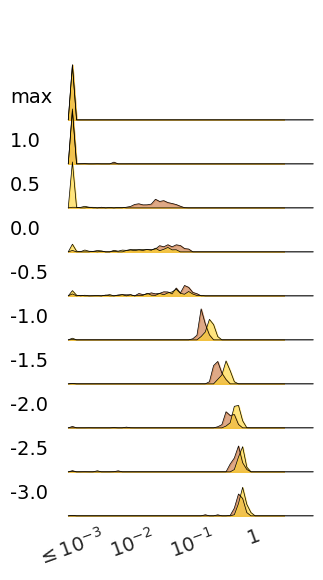

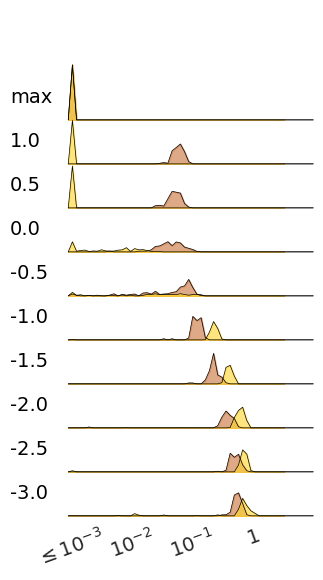

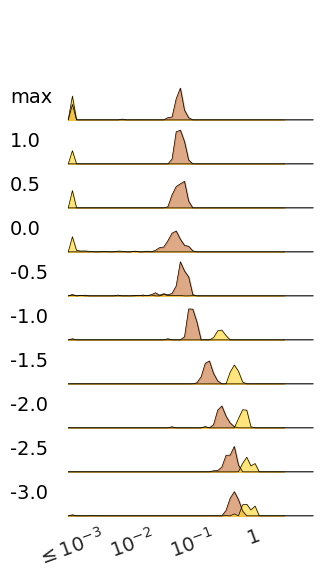

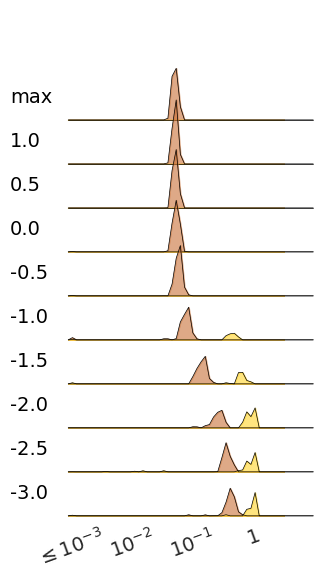

In [10]:
nR = 2
tau0, p, D= 0.3, 0.5, 100.0
alphas = list(10**np.linspace(-3, 1, 9)) + ["max"]
alpha_names = list(np.linspace(-3, 1, 9)) + ["max"]
nbins = 60

qs = [0.1, 0.2, 0.3, 0.4]

for q in qs:
    freqs_1 = []
    freqs_2 = []
    x_values = []
    for a in alphas[::-1]:
        q = 1-(1-q)**(1/(nR-1))
        data = pickle.load(open(f"data/with_leaky_1/evolution_with_cout_a={a}_q={q}_p={p}_D={D}_tau0={tau0}_random_nR={nR}_1.pkl", "rb"))
        sum_all = 0
        for idx in range(2):
            all_pairs = []
            for sample in data:
                all_pairs.extend(get_phi_pref(sample, idx+1))
            bin_centers, bin_heights = make_hist(all_pairs, nbins)
            sum_all+=np.sum(bin_heights)
            # print(a, q, np.sum(bin_heights))
        for idx in range(2):
            all_pairs = []
            for sample in data:
                all_pairs.extend(get_phi_pref(sample, idx+1))
            bin_centers, bin_heights = make_hist(all_pairs, nbins)
            x_values.append(bin_centers)
            [freqs_1, freqs_2][idx].append([i/sum_all for i in bin_heights])
            
        

    '''
    df:
    "x" - bin centers across 1e-5(0) to 1e0
    "freq" - propto biomass
    "g" - name of group, alpha here
    '''
    df_list = []
    for idx, g in enumerate(alpha_names[::-1]):
        df_tmp = pd.DataFrame({
            "x": x_values[idx],
            "freq1": freqs_1[idx],
            "freq2": freqs_2[idx],
            "g": g
        })
        df_list.append(df_tmp)
    df = pd.concat(df_list, ignore_index=True)

    # make ridgeplot
    with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
        g = sns.FacetGrid(df, row="g", aspect=6, height=.6)
        g.l_idx = 0

        def ridgeplot(x, freq, color, **kwargs):
            ax = plt.gca()
            ax.plot(x, freq, color="k", lw=0.5, clip_on=False)
            # ax.plot([-4, 0.5], [0, 0], color="k", lw=1)
            ax.fill_between(x, 0, freq, color=color, alpha=0.6)
        g.map(ridgeplot, "x", "freq1", color="#c87137", alpha=0.8)
        g.map(ridgeplot, "x", "freq2", color="#ffd42a", alpha=0.8)
        # g.refline(y=0, linewidth=1, linestyle="-", color="gray", clip_on=False)
        
        def label(x, color, **kwargs):
            ax = plt.gca()
            label = alpha_names[::-1][g.l_idx]
            g.l_idx += 1
            ax.text(0, 0.2, label, color=color,
                    ha="left", va="center", transform=ax.transAxes)
        g.map(label, "x", color="k")

        g.figure.subplots_adjust(hspace=-.6)
        g.despine(bottom=True, left=True)

        # g.figure.set_size_inches(4, 8)
        g.set(xlim=(-4, 0.5), 
        xticks=[-3, -2, -1, 0],
        xticklabels=["$\\leq 10^{-3}$", "$10^{-2}$", "$10^{-1}$", "1"],
        xlabel="",
        ylim=(0, 1.0), 
        yticks=[], 
        ylabel="", 
        title="")
        # plt.show()
        for ax in g.axes.flat:
            plt.setp(ax.get_xticklabels(), rotation=20)

    plt.savefig(f"figs/vers2/fixq_hist_q={round(q, 2)}.pdf", bbox_inches="tight")

#### check the distribution of pre-allocation phi

In [26]:
nR = 2
tau0, p, D= 0.5, 0.5, 100.0
a, q = 10**-1.0, 0.0
q = 1-(1-q)**(1/(nR-1))
data = pickle.load(open(f"data/with_leaky_1/evolution_with_cout_a={a}_q={q}_p={p}_D={D}_tau0={tau0}_random_nR={nR}_1.pkl", "rb"))

def make_hist(pairs, nbins, nR=2):
    factor = nR/(nR-1)
    # a1_values = np.array([max(-4, np.log10(pair[0]*factor)) for pair in pairs])
    a1_values = np.array([max(-3, np.log10(pair[0]*factor)) for pair in pairs])
    a2_values = np.array([pair[1] for pair in pairs])
    # xlo, xhi = -5.01, 1.01
    xlo, xhi = -3.01, 1.01
    bins = np.linspace(xlo, xhi, nbins + 1)
    bin_indices = np.digitize(a1_values, bins) - 1
    bin_heights = np.zeros(nbins)
    for i, bin_idx in enumerate(bin_indices):
        if 0 <= bin_idx < nbins:  # Ignore out-of-range values
            bin_heights[bin_idx] += a2_values[i]
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.bar(bin_centers, bin_heights, width=np.diff(bins), color="k", edgecolor='k', align='center', alpha=0.4)
    # plt.xlim(-4.6, 0.1)
    # plt.xticks([-4, -3, -2, -1, 0], ["$\\leq 10^{-4}$", "$10^{-3}$", "$10^{-2}$", "$10^{-1}$", "1"])
    plt.xlim(-3.4, 0.1)
    plt.xticks([-3, -2, -1, 0], ["$\\leq 10^{-3}$", "$10^{-2}$", "$10^{-1}$", "1"])
    plt.yticks([])
    # plt.axvline(-4, color="k", linestyle="-.", alpha = 0.5)
    plt.xlabel("${\\phi}$")
    plt.ylabel("Histogram")
    # plt.title(f"$\\alpha={round(a, 2)}, q={q}$")

# from matplotlib.colors import LinearSegmentedColormap, Normalize
# def make_hist(pairs, nbins, nR=2):
    
#     factor = nR / (nR - 1)
#     a1_values = np.array([max(-3, np.log10(pair[0] * factor)) for pair in pairs])
#     a2_values = np.array([pair[1] for pair in pairs])
    
#     # Define bin range
#     xlo, xhi = -3.01, 0.01
#     bins = np.linspace(xlo, xhi, nbins + 1)
    
#     # Digitizing values to bins and summing heights
#     bin_indices = np.digitize(a1_values, bins) - 1
#     bin_heights = np.zeros(nbins)
    
#     for i, bin_idx in enumerate(bin_indices):
#         if 0 <= bin_idx < nbins:
#             bin_heights[bin_idx] += a2_values[i]
            
#     bin_centers = (bins[:-1] + bins[1:]) / 2
    
#     norm_positions = [0.0, 0.5, 1.0]
    
#     # Colors (Hex codes): Using new strong, distinct colors
#     colors = ["#6AAF38",   # Muted Green / Dusty Olive (phi = -3)
#               "#267BC1",   # Muted Blue / Slate Blue (phi = -2)
#               "#D92F2F"]   # Muted Red / Terracotta (phi = 1)
    
#     nodes = []
#     for pos, color in zip(norm_positions, colors):
#         nodes.append((pos, color))
    
#     custom_cmap = LinearSegmentedColormap.from_list("custom_gradient", nodes)
#     norm = Normalize(vmin=-3, vmax=0)
#     bar_colors = custom_cmap(norm(bin_centers))
    
#     plt.bar(
#         bin_centers, 
#         bin_heights, 
#         width=np.diff(bins), 
#         color=bar_colors, # Use the computed array of gradient colors
#         edgecolor=None, 
#         align='center', 
#         alpha=0.9
#     )

    
#     plt.xlim(-3.4, 0.1)
#     plt.xticks([-3, -2, -1, 0], ["$\\leq 10^{-3}$", "$10^{-2}$", "$10^{-1}$", "1"])
#     plt.yticks([])
#     # plt.axvline(-4, color="k", linestyle="-.", alpha = 0.5)
#     plt.xlabel("${\\phi}$")
#     plt.ylabel("Histogram")
    
# all_pairs = []
# for sample in data:
#     all_pairs.extend(get_phi(sample, "seq"))
#     all_pairs.extend(get_phi(sample, "spec"))

# plt.figure(figsize=(4, 1.5))
# make_hist(all_pairs, 50)
# plt.yscale("log")



[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]


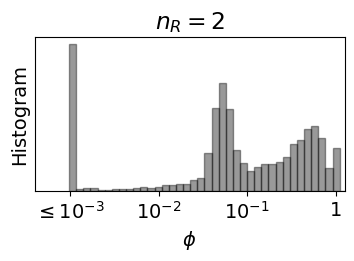

In [27]:
nR = 2
tau0, p, D= 0.3, 0.5, 100.0
qs = list(np.round(np.linspace(0.0, 0.5, 11), 2))
# qs = qs[4:5]
print(qs)
alphas = list(10**np.linspace(-3, 1, 9)) + ["max"]

all_pairs = []
for a in alphas:
    for q in qs:
        q = 1-(1-q)**(1/(nR-1))
        data = pickle.load(open(f"data/with_leaky_1/evolution_with_cout_a={a}_q={q}_p={p}_D={D}_tau0={tau0}_random_nR={nR}_1.pkl", "rb"))
        for sample in data:
            all_pairs.extend(get_phi(sample, "seq"))
            all_pairs.extend(get_phi(sample, "spec"))

plt.figure(figsize=(4, 2))
make_hist(all_pairs, 50, nR)
plt.title("$n_R=2$")
# plt.axvspan(-6, -4, color=soft_green, alpha=0.2)
# plt.axvspan(-4, -0.8, color=soft_blue, alpha=0.1)
# plt.axvspan(-0.8, 1, color=soft_red, alpha=0.1)
# plt.axvline(-1,  color="k", linestyle="-.", alpha=0.5)
# plt.yscale("log")
plt.savefig("figs/vers2/fig2_3peaks.pdf", bbox_inches="tight")

10it [00:02,  4.48it/s]


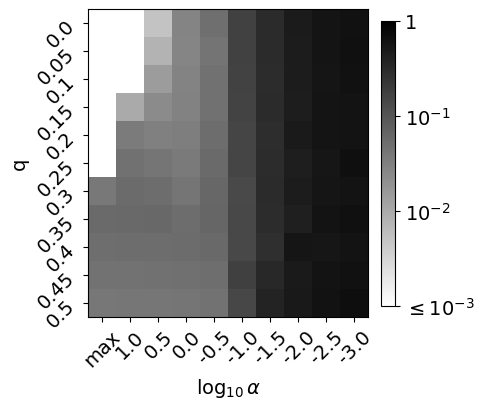

In [ ]:
alphas = (list(10**np.linspace(-3, 1, 9)) + ["max"])[::-1]
tau0, p, D= 0.3, 0.5, 100.0
qs = list(np.round(np.linspace(0.0, 0.5, 11), 2))
nR = 2

avr_log_phis = np.zeros([len(alphas), len(qs)])
for idx, a in tqdm(enumerate(alphas)):
    for jdx, q in enumerate(qs):
        q = 1-(1-q)**(1/(nR-1))
        data = pickle.load(open(f"data/with_leaky_1/evolution_with_cout_a={a}_q={q}_p={p}_D={D}_tau0={tau0}_random_nR={nR}_1.pkl", "rb"))
        all_pairs = []
        for sample in data:
            all_pairs.extend(get_phi(sample, "seq"))
            all_pairs.extend(get_phi(sample, "spec"))
        factor = nR#/(nR-1)
        elem = np.log10(np.sum([i[0]*i[1] for i in all_pairs]) / np.sum([i[1] for i in all_pairs])) + np.log10(factor)
        # elem = np.sum([i[1]*np.log10(i[0]) for i in all_pairs]) / np.sum([i[1] for i in all_pairs]) + np.log10(nR)
        surv_list = []
        for sample in data:
            surv_list.extend(sample[0])
        avr_log_phis[idx, jdx] = elem

data = avr_log_phis.T
# norm = mcolors.Normalize(vmin=-4, vmax=0)
norm = mcolors.Normalize(vmin=-3, vmax=0)
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(data, cmap=cmap_gray, norm=norm)
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
# cbar.set_ticks([0, -1, -2, -3, -4])
# cbar.set_ticklabels(["$\\leq 10^{-4}$", "$10^{-3}$", "$10^{-2}$", "$10^{-1}$", "1"][::-1])
cbar.set_ticks([0, -1, -2, -3])
cbar.set_ticklabels(["$\\leq 10^{-3}$", "$10^{-2}$", "$10^{-1}$", "1"][::-1])
plt.xlabel("$\\log_{10}\\alpha$")
plt.xticks(range(len(alphas)), (list(np.round(np.linspace(-3, 1, 9), 2))+["max"])[::-1], rotation=45)
plt.ylabel("q")
plt.yticks(range(len(qs)), [round(i, 2) for i in qs], rotation=45)
plt.savefig("figs/vers2/fig2_2spc_phi.pdf", bbox_inches="tight")
plt.show()

#### 3-phase boundaries

In [4]:
alphas = list(10**np.linspace(-3, 1, 9)) + ["max"]
tau0, p, D= 0.3, 0.5, 100.0
qs = list(np.round(np.linspace(0.0, 0.5, 11), 2))
nR = 2

phases = np.zeros([len(alphas), len(qs)])
t1, t2 = -3, -1
for idx, a in tqdm(enumerate(alphas[::-1])):
    for jdx, q in enumerate(qs):
        if(avr_log_phis[idx, jdx]<t1):
            phases[idx, jdx] = 0
        elif(t1<avr_log_phis[idx, jdx]<t2):
            phases[idx, jdx]=1
        else:
            phases[idx, jdx]=2

plt.figure(figsize=(5, 5))
data = phases.T
plt.imshow(data, cmap=cmap_phase)
plt.xlabel("$\\log_{10}\\alpha$")
plt.xticks(range(len(alphas)), (list(np.round(np.linspace(-3, 1, 9), 2))+["max"])[::-1], rotation=45)
plt.ylabel("q")
plt.yticks(range(len(qs)), [round(i, 2) for i in qs], rotation=45)
# plt.savefig("fig3_4spc_phi.pdf", bbox_inches="tight")
plt.show()

0it [00:00, ?it/s]


NameError: name 'avr_log_phis' is not defined

#### Thoughts on explaining the phases

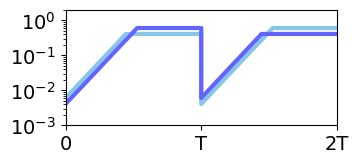

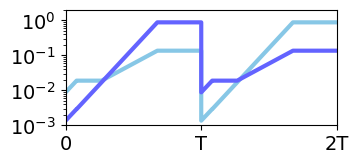

In [3]:
# try plotting the high and low fluctuations
b0 = 2e-1
R0 = 0.4
T_dilute = 12
g11, q, p = 0.8, 0.0, 0.5
g12 = g11*(1-q)*p
g21 = g11*p
g22 = g11*(1-q)
tau0 = 0.6
phi = 0.05
D = 100

params_list = [[0.4, 0.05], [0.01, 0.05]]
idx = 0
for params in params_list:
    R0, phi = params
    b1 = LeakySeqUt(phi=phi, g_enz=np.array([g11, g12]), gC=1.0, pref_list=(1, 2), tau0=tau0, biomass=b0, id="1")
    b2 = LeakySeqUt(phi=phi, g_enz=np.array([g21, g22]), gC=1.0, pref_list=(2, 1), tau0=tau0, biomass=b0, id="2")
    C = EcoSystem([b1, b2])
    for i in range(60):
        C.OneCycle(np.array([R0, 1-R0]), T_dilute)
        C.MoveToNext(D)
        c1 = C.last_cycle
        C.OneCycle(np.array([1-R0, R0]), T_dilute)
        C.MoveToNext(D)
        c2 = C.last_cycle
    ts = c1["ts"]+[i+T_dilute for i in c2["ts"]]
    sp1s = [i[0] for i in c1["bs"]] + [i[0] for i in c2["bs"]]
    sp2s = [i[1] for i in c1["bs"]] + [i[1] for i in c2["bs"]]

    plt.figure(figsize=(3.5, 1.5))
    plt.plot(ts, sp1s, color="#87c7e6", lw=3)
    plt.plot(ts, sp2s, color="#6363ff", lw=3)
    plt.xlim(0, 24)
    plt.xticks([0, 12, 24], [0, "T", "2T"])
    plt.yscale("log")
    plt.ylim(1e-3, 2)
    plt.savefig(f"figs/vers2/fig3_growth_{idx}.pdf", bbox_inches="tight")
    idx+=1
    plt.show()

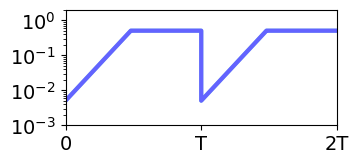

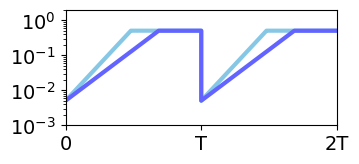

In [5]:
b0 = 2e-1
R0 = 0.4
T_dilute = 12
g11, q, p = 0.8, 0.1, 0.5
tau0 = 0.6
phi = 0.05
D = 100

qs = [0, 0.3]
idx = 0
for q in qs:
    R0, phi = 0.5, 0.01
    g12 = g11*(1-q)*p
    g21 = g11*p
    g22 = g11*(1-q)
    b1 = LeakySeqUt(phi=phi, g_enz=np.array([g11, g12]), gC=1.0, pref_list=(1, 2), tau0=tau0, biomass=b0, id="1")
    b2 = LeakySeqUt(phi=phi, g_enz=np.array([g21, g22]), gC=1.0, pref_list=(2, 1), tau0=tau0, biomass=b0, id="2")
    C = EcoSystem([b1, b2])
    for i in range(20):
        C.OneCycle(np.array([R0, 1-R0]), T_dilute)
        C.MoveToNext(D)
        c1 = C.last_cycle
        C.OneCycle(np.array([1-R0, R0]), T_dilute)
        C.MoveToNext(D)
        c2 = C.last_cycle
    ts = c1["ts"]+[i+T_dilute for i in c2["ts"]]
    sp1s = [i[0] for i in c1["bs"]] + [i[0] for i in c2["bs"]]
    sp2s = [i[1] for i in c1["bs"]] + [i[1] for i in c2["bs"]]

    plt.figure(figsize=(3.5, 1.5))
    plt.plot(ts, sp1s, color="#87c7e6", lw=3)
    plt.plot(ts, sp2s, color="#6363ff", lw=3)
    plt.xlim(0, 24)
    plt.xticks([0, 12, 24], [0, "T", "2T"])
    plt.yscale("log")
    plt.ylim(1e-3, 2)
    plt.savefig(f"figs/vers2/fig3_growth_{idx+2}.pdf", bbox_inches="tight")
    idx+=1
    plt.show()

10it [00:01,  5.41it/s]


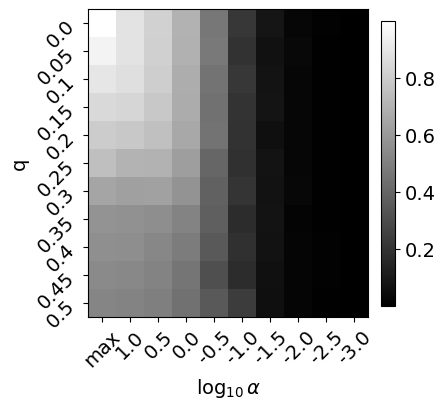

In [ ]:
# fraction of primary/secondary temporal niches
alphas = (list(10**np.linspace(-3, 1, 9)) + ["max"])[::-1]
tau0, p, D= 0.3, 0.5, 100.0
qs = list(np.round(np.linspace(0.0, 0.5, 11), 2))
nR = 2
all_dep_times = np.zeros([len(alphas), len(qs)])
all_first_niches = np.zeros([len(alphas), len(qs)])
all_delta_deps = np.zeros([len(alphas), len(qs)])
for idx, a in tqdm(enumerate(alphas)):
    for jdx, q in enumerate(qs):
        q = 1-(1-q)**(1/(nR-1))
        data = pickle.load(open(f"data/with_leaky_1/evolution_with_cout_a={a}_q={q}_p={p}_D={D}_tau0={tau0}_random_nR={nR}_1.pkl", "rb"))
        dep_times = []
        first_niches = []
        for i in data:
            dep_times.append(i[1]["ts"][-2])
            first_niches.append (i[1]["ts"][1])
        all_dep_times[idx, jdx] = np.mean(dep_times)
        all_first_niches[idx, jdx] = np.mean(first_niches) / np.mean(dep_times)
        all_delta_deps[idx, jdx] = 1 - all_first_niches[idx, jdx]
data = all_first_niches.T

fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(data, cmap="gray")
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.xlabel("$\\log_{10}\\alpha$")
plt.xticks(range(len(alphas)), (list(np.round(np.linspace(-3, 1, 9), 2))+["max"])[::-1], rotation=45)
plt.ylabel("q")
plt.yticks(range(len(qs)), [round(i, 2) for i in qs], rotation=45)
plt.savefig("figs/vers2/fig3_time_frac.pdf", bbox_inches="tight")
plt.show()

10it [00:02,  3.46it/s]


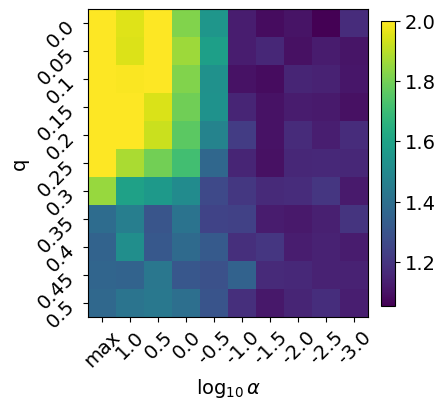

In [34]:
alphas = (list(10**np.linspace(-3, 1, 9)) + ["max"])[::-1]
tau0, p, D= 0.3, 0.5, 100.0
qs = list(np.round(np.linspace(0.0, 0.5, 11), 2))
nR = 2
shannon_diversity = np.zeros([len(alphas), len(qs)])
for idx, a in tqdm(enumerate(alphas)):
    for jdx, q in enumerate(qs):
        q = 1-(1-q)**(1/(nR-1))
        data = pickle.load(open(f"data/with_leaky_1/evolution_with_cout_a={a}_q={q}_p={p}_D={D}_tau0={tau0}_random_nR={nR}_1.pkl", "rb"))
        shannon_diversity[idx, jdx] = min(nR, np.mean([get_shannon_index(i) for i in data]))
data = shannon_diversity.T

fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(data, cmap="viridis")
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.yticks(range(len(qs)), [round(i, 2) for i in qs], rotation=45)
plt.xticks(range(len(alphas)), (list(np.round(np.linspace(-3, 1, 9), 2))+["max"])[::-1], rotation=45)
plt.ylabel("q")
plt.xlabel("$\\log_{10}\\alpha$")
plt.savefig("figs/vers2/fig3_shannon_div.pdf", bbox_inches="tight")
plt.show()

#### Variation with lag coefficient $\tau_0$ (deprecated)

In [64]:
alphas = list(10**np.linspace(-3, 1, 9)) + ["max"]
p, D = 0.5, 100
qs = list(np.round(np.linspace(0.0, 0.5, 11), 2))
nR = 2
tau_list = list(np.round(np.linspace(0.1, 0.9, 5), 2))

def make_hist(pairs, nbins, ax, nR=2):
    # a1_values = np.array([max(-4, np.log10(pair[0]*nR)) for pair in pairs])
    a1_values = np.array([max(-3, np.log10(pair[0]*nR)) for pair in pairs])
    a2_values = np.array([pair[1] for pair in pairs])
    # xlo, xhi = -4.01, 1.01
    xlo, xhi = -3.01, 1.01
    bins = np.linspace(xlo, xhi, nbins + 1)
    bin_indices = np.digitize(a1_values, bins) - 1
    bin_heights = np.zeros(nbins)
    for i, bin_idx in enumerate(bin_indices):
        if 0 <= bin_idx < nbins:  # Ignore out-of-range values
            bin_heights[bin_idx] += a2_values[i]
    bin_centers = (bins[:-1] + bins[1:]) / 2
    ax.bar(bin_centers, bin_heights, width=np.diff(bins), color="k", edgecolor='k', align='center', alpha=0.4)
    # ax.set_xlim(-4.5, 0.1)
    ax.set_xlim(-3.4, 0.1)
    # ax.set_xticks([-4, -3, -2, -1, 0], ["$\\leq 10^{-4}$", "$10^{-3}$", "$10^{-2}$", "$10^{-1}$", "1"], rotation=40)
    ax.set_yticks([])
    # ax.axvline(-4, color="k", linestyle="-.")
    # ax.set_xlabel("$\\phi\\cdot n_R$")
    # ax.set_ylabel("Histogram")

100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


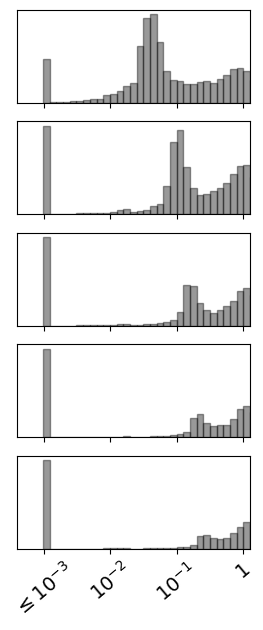

In [65]:
fig, axes = plt.subplots(5, 1, figsize=(3, 7), sharex=True, sharey=False)
for idx_t in tqdm(range(len(tau_list))):
    tau0 = tau_list[idx_t]
    all_pairs = []
    for a in alphas:
        for q in qs:
            q = 1-(1-q)**(1/(nR-1))
            data = pickle.load(open(f"data/with_leaky_1_simple/evolution_with_cout_a={a}_q={q}_p={p}_D={D}_tau0={tau0}_random_nR={nR}_1.pkl", "rb"))
            for sample in data:
                all_pairs.extend(get_phi(sample, "seq"))
                all_pairs.extend(get_phi(sample, "spec"))
    ax = axes[idx_t]
    make_hist(all_pairs, 40, ax, nR)
    if(idx_t>0):
        ax.set_ylabel("")
# axes[-1].set_xticks([-4, -3, -2, -1, 0], ["$\\leq 10^{-4}$", "$10^{-3}$", "$10^{-2}$", "$10^{-1}$", "1"], rotation=40)
axes[-1].set_xticks([-3, -2, -1, 0], ["$\\leq 10^{-3}$", "$10^{-2}$", "$10^{-1}$", "1"], rotation=40)
# plt.savefig(f"figs/vers2/fig3_t_hist.pdf", bbox_inches="tight")

In [19]:
print(f"data/with_leaky_1_simple/evolution_with_cout_a={a}_q={q}_p={p}_D={D}_tau0={tau0}_random_nR={nR}_1.pkl")

data/with_leaky_1_simple/evolution_with_cout_a=max_q=0.5_p=0.5_D=100_tau0=0.9_random_nR=2_1.pkl


#### Check with more resources

In [3]:
def make_hist(pairs, nbins, nR=2, makeplot=False):
    factor = 1
    # a1_values = np.array([max(-4, np.log10(pair[0]*factor)) for pair in pairs])
    # a2_values = np.array([pair[1] for pair in pairs])
    # xlo, xhi = -4.01, 1.01
    a1_values = np.array([max(-3, np.log10(pair[0]*factor)) for pair in pairs])
    a2_values = np.array([pair[1] for pair in pairs])
    xlo, xhi = -3.01, 1.01
    bins = np.linspace(xlo-(xhi-xlo)/(nbins-1), xhi, nbins + 1)
    bin_indices = np.digitize(a1_values, bins) - 1
    bin_heights = np.zeros(nbins)
    for i, bin_idx in enumerate(bin_indices):
        if 0 <= bin_idx < nbins:  # Ignore out-of-range values
            bin_heights[bin_idx] += a2_values[i]
    bin_centers = (bins[:-1] + bins[1:]) / 2
    if(makeplot):
        plt.bar(bin_centers, bin_heights, width=np.diff(bins), color="k", edgecolor='k', align='center', alpha=0.4)
        # plt.xlim(-4.1, 0.1)
        # plt.xticks([-4, -3, -2, -1, 0], ["$\\leq 10^{-4}$", "$10^{-3}$", "$10^{-2}$", "$10^{-1}$", "1"])
        # plt.axvline(-3.5, color="k", linestyle="-.")
        plt.xlim(-3.1, 0.1)
        plt.xticks([-3, -2, -1, 0], ["$\\leq 10^{-3}$", "$10^{-2}$", "$10^{-1}$", "1"])
        # plt.axvline(-2.5, color="k", linestyle="-.")
        plt.xlabel("$\\phi$")
        plt.ylabel("Histogram")
    return bin_centers, bin_heights

100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


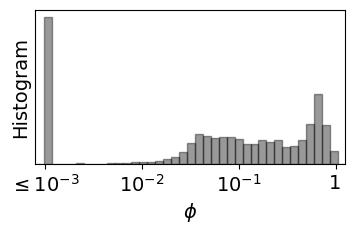

100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


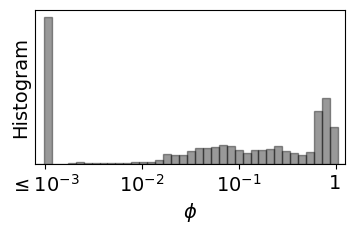

In [5]:
nRs = [3, 4]
tau0, p, D= 0.3, 0.5, 100.0
qs = list(np.round(np.linspace(0.0, 0.5, 11), 2))
alphas = list(10**np.linspace(-3, 1, 9)) + ["max"]

for nR in nRs:
    all_pairs = []
    for a in tqdm(alphas):
        for q in qs:
            q = 1-(1-q)**(1/(nR-1))
            try:
                data = pickle.load(open(f"data/with_leaky_1/evolution_with_cout_a={a}_q={q}_p={p}_D={D}_tau0={tau0}_random_nR={nR}_2.pkl", "rb"))
                # print(f"data/with_leaky_1/evolution_with_cout_a={a}_q={q}_p={p}_D={D}_tau0={tau0}_random_nR={nR}_1.pkl")
            except:
                print(a)
                continue
            for sample in data:
                all_pairs.extend(get_phi(sample, "seq"))
                all_pairs.extend(get_phi(sample, "spec"))
    plt.figure(figsize=(4, 2))
    make_hist(all_pairs, 50, nR, True)

    # plt.axvspan(-6, -4, color=soft_green, alpha=0.2)
    # plt.axvspan(-4, -0.8, color=soft_blue, alpha=0.1)
    # plt.axvspan(-0.8, 1, color=soft_red, alpha=0.1)
    
    # plt.axvline(-1,  color="k", linestyle="-.")
    plt.yticks([], [])
    # plt.yscale("log")
    plt.savefig(f"figs/vers2/fig4_{nR}res_3peaks.pdf", bbox_inches="tight")
    plt.show()

In [ ]:
a = 1e-2
q = 
data = pickle.load(open(f"data/with_leaky_1/evolution_with_cout_a={a}_q={q}_p={p}_D={D}_tau0={tau0}_random_nR={nR}_1.pkl", "rb"))
[i.phi for i in data[0][0]]

[1e-200, 1e-200, 1e-200, 1e-200]

/home/n-z/zihanw8/sci-comp/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/n-z/zihanw8/sci-comp/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


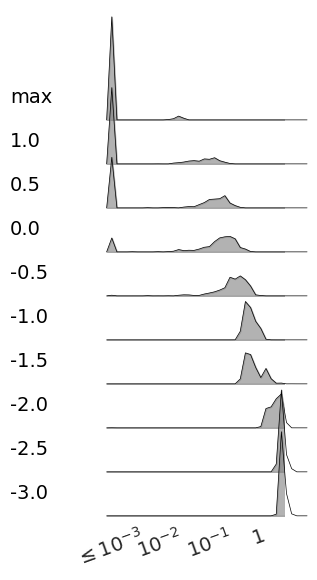

In [19]:
nR = 4
tau0, p, D= 0.3, 0.5, 100.0
q = list(np.round(np.linspace(0.0, 0.5, 11), 2))[6]
q = 1-(1-q)**(1/(nR-1))
alphas = list(10**np.linspace(-3, 1, 9)) + ["max"]
alpha_names = list(np.linspace(-3, 1, 9)) + ["max"]
nbins = 40


freqs = []
x_values = []
for a in alphas[::-1]:
	data = pickle.load(open(f"data/with_leaky_1/evolution_with_cout_a={a}_q={q}_p={p}_D={D}_tau0={tau0}_random_nR={nR}_1.pkl", "rb"))
	all_pairs = []
	for sample in data:
		all_pairs.extend(get_phi(sample, "seq"))
		all_pairs.extend(get_phi(sample, "spec"))
	bin_centers, bin_heights = make_hist(all_pairs, nbins, nR, False)
	x_values.append(bin_centers)
	freqs.append([i/np.sum(bin_heights) for i in bin_heights])

'''
df:
"x" - bin centers across 1e-5(0) to 1e0
"freq" - propto biomass
"g" - name of group, alpha here
'''
df_list = []
for idx, g in enumerate(alpha_names[::-1]):
	df_tmp = pd.DataFrame({
		"x": x_values[idx],
		"freq": freqs[idx],
		"g": g
	})
	df_list.append(df_tmp)
df = pd.concat(df_list, ignore_index=True)

# make ridgeplot
with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
	g = sns.FacetGrid(df, row="g", aspect=6, height=.6)
	g.l_idx = 0

	def ridgeplot(x, freq, color, **kwargs):
		ax = plt.gca()
		ax.plot(x, freq, color="k", lw=0.5, clip_on=False)
		# ax.plot([-4, 0.5], [0, 0], color="k", lw=1)
		ax.fill_between(x, 0, freq, color=color, alpha=0.6)
	g.map(ridgeplot, "x", "freq", color="gray")
	# g.refline(y=0, linewidth=1, linestyle="-", color="gray", clip_on=False)
	
	def label(x, color, **kwargs):
		ax = plt.gca()
		label = alpha_names[::-1][g.l_idx]
		g.l_idx += 1
		ax.text(0, 0.2, label, color=color,
				ha="left", va="center", transform=ax.transAxes)
	g.map(label, "x", color="k")

	g.figure.subplots_adjust(hspace=-.6)
	g.despine(bottom=True, left=True)

	# g.figure.set_size_inches(4, 8)
	g.set(xlim=(-5, 0.5), 
	#    xticks=[-4, -3, -2, -1, 0],
	#    xticklabels=["$\\leq 10^{-4}$", "$10^{-3}$", "$10^{-2}$", "$10^{-1}$", "1"],
	   xticks=[-3, -2, -1, 0],
	   xticklabels=["$\\leq 10^{-3}$", "$10^{-2}$", "$10^{-1}$", "1"],
	   xlabel="",
      ylim=(0, 1.0), 
	  yticks=[], 
	  ylabel="", 
	  title="")
	# plt.show()
	for ax in g.axes.flat:
		plt.setp(ax.get_xticklabels(), rotation=20)

In [46]:
nR = 3
q = 0.25
1-(1-q)**(1/(nR-1))

0.1339745962155614

10it [00:02,  3.57it/s]


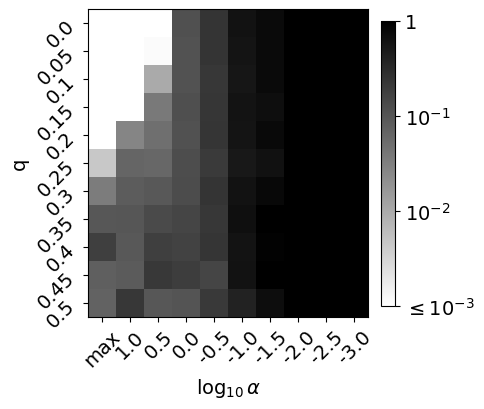

10it [00:00, 96866.14it/s]


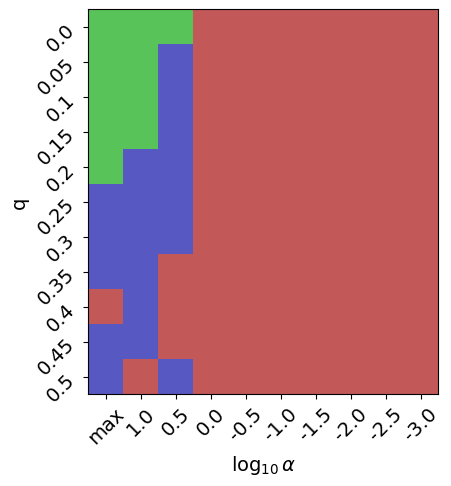

10it [00:03,  2.79it/s]


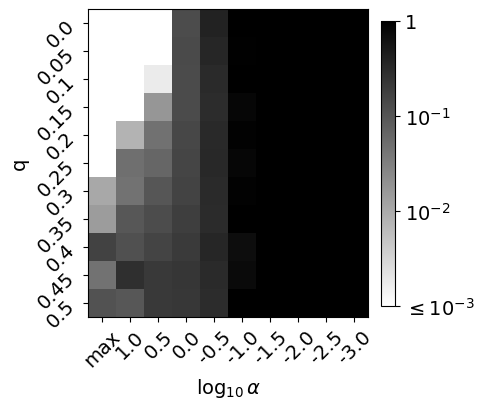

10it [00:00, 104077.02it/s]


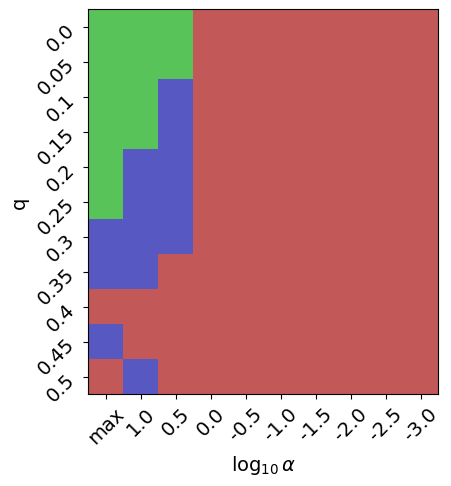

In [6]:
nRs = [3, 4]
tau0, p, D= 0.3, 0.5, 100.0
qs = list(np.round(np.linspace(0.0, 0.5, 11), 2))
alphas = (list(10**np.linspace(-3, 1, 9)) + ["max"])[::-1]

for nR in nRs:
    avr_log_phis = np.zeros([len(alphas), len(qs)])
    for idx, a in tqdm(enumerate(alphas)):
        for jdx, q in enumerate(qs):
            q = 1-(1-q)**(1/(nR-1))
            data = pickle.load(open(f"data/with_leaky_1/evolution_with_cout_a={a}_q={q}_p={p}_D={D}_tau0={tau0}_random_nR={nR}_2.pkl", "rb"))
            all_pairs = []
            for sample in data:
                all_pairs.extend(get_phi(sample, "seq"))
                all_pairs.extend(get_phi(sample, "spec"))
            elem = np.log10(np.sum([i[0]*i[1] for i in all_pairs]) / np.sum([i[1] for i in all_pairs])) + np.log10(nR)
            # elem = np.sum([i[1]*max(-4, np.log10(i[0])) for i in all_pairs]) / np.sum([i[1] for i in all_pairs]) + np.log10(nR)
            surv_list = []
            for sample in data:
                surv_list.extend(sample[0])
            avr_log_phis[idx, jdx] = elem

    data = avr_log_phis.T
    # norm = mcolors.Normalize(vmin=-4, vmax=0)
    norm = mcolors.Normalize(vmin=-3, vmax=0)
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(data, cmap=cmap_gray, norm=norm)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    # cbar.set_ticks([0, -1, -2, -3, -4])
    # cbar.set_ticklabels(["$\\leq 10^{-4}$", "$10^{-3}$", "$10^{-2}$", "$10^{-1}$", "1"][::-1])
    cbar.set_ticks([0, -1, -2, -3])
    cbar.set_ticklabels(["$\\leq 10^{-3}$", "$10^{-2}$", "$10^{-1}$", "1"][::-1])
    plt.xlabel("$\\log_{10}\\alpha$")
    plt.xticks(range(len(alphas)), (list(np.round(np.linspace(-3, 1, 9), 2))+["max"])[::-1], rotation=45)
    plt.ylabel("q")
    plt.yticks(range(len(qs)), [round(i, 2) for i in qs], rotation=45)
    # plt.savefig(f"figs/vers2/fig4_{nR}res_phase.pdf", bbox_inches="tight")
    plt.show()

    phases = np.zeros([len(alphas), len(qs)])
    t1, t2 = -3, -1
    for idx, a in tqdm(enumerate(alphas[::-1])):
        for jdx, q in enumerate(qs):
            if(avr_log_phis[idx, jdx]<t1):
                phases[idx, jdx] = 0
            elif(t1<avr_log_phis[idx, jdx]<t2):
                phases[idx, jdx]=1
            else:
                phases[idx, jdx]=2

    plt.figure(figsize=(5, 5))
    data = phases.T
    plt.imshow(data, cmap=cmap_phase)
    plt.xlabel("$\\log_{10}\\alpha$")
    plt.xticks(range(len(alphas)), (list(np.round(np.linspace(-3, 1, 9), 2))+["max"])[::-1], rotation=45)
    plt.ylabel("q")
    plt.yticks(range(len(qs)), [round(i, 2) for i in qs], rotation=45)
    plt.show()

In [90]:
avr_log_phis.T

array([[-199.87506126, -199.87506126,   -1.93610161,   -1.32974346,
          -0.94988216,   -0.50004501,   -0.49287607,   -0.44518861,
          -0.37033742,   -0.29617705],
       [-199.87506126,   -4.84188984,   -1.90827555,   -1.31633388,
          -0.96255834,   -0.52094166,   -0.51640786,   -0.43618383,
          -0.37082108,   -0.34067257],
       [ -11.43950101,   -3.52976506,   -1.82571053,   -1.32378591,
          -0.9385425 ,   -0.54037272,   -0.53703934,   -0.46209972,
          -0.36206675,   -0.34535402],
       [-199.87506126,   -2.53338222,   -1.75954871,   -1.2930764 ,
          -0.93865454,   -0.55706334,   -0.56314915,   -0.45948031,
          -0.39113849,   -0.36026059],
       [-199.87506126,   -2.07501458,   -1.62400608,   -1.26584829,
          -0.96174293,   -0.58183728,   -0.57435417,   -0.47863386,
          -0.40919603,   -0.35977481],
       [  -3.14637299,   -1.88942906,   -1.54126471,   -1.25735528,
          -0.93918065,   -0.60152517,   -0.59675309,   -0

10it [00:05,  1.81it/s]


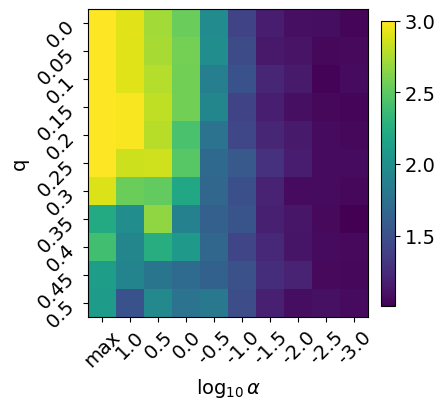

10it [00:06,  1.57it/s]


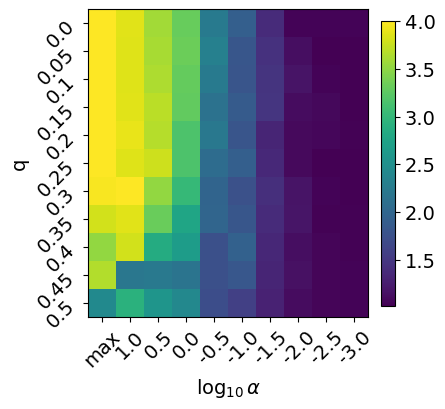

In [7]:
nRs = [3, 4]
tau0, p, D= 0.5, 0.5, 100.0
qs = list(np.round(np.linspace(0.0, 0.5, 11), 2))
alphas = (list(10**np.linspace(-3, 1, 9)) + ["max"])[::-1]

for nR in nRs:
    tau0, p, D= 0.3, 0.5, 100.0
    shannon_diversity = np.zeros([len(alphas), len(qs)])
    for idx, a in tqdm(enumerate(alphas)):
        for jdx, q in enumerate(qs):
            if(nR>2):
                q = 1-(1-q)**(1/(nR-1))
            data = pickle.load(open(f"data/with_leaky_1/evolution_with_cout_a={a}_q={q}_p={p}_D={D}_tau0={tau0}_random_nR={nR}_2.pkl", "rb"))
            shannon_diversity[idx, jdx] = min(nR, np.mean([get_shannon_index(i) for i in data]))
    data = shannon_diversity.T

    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(data, cmap="viridis")
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.yticks(range(len(qs)), [round(i, 2) for i in qs], rotation=45)
    plt.xticks(range(len(alphas)), (list(np.round(np.linspace(-3, 1, 9), 2))+["max"])[::-1], rotation=45)
    plt.ylabel("q")
    plt.xlabel("$\\log_{10}\\alpha$")
    plt.savefig(f"figs/vers2/fig4_{nR}res_shannon_div.pdf", bbox_inches="tight")
    plt.show()